## Test with Pure MLServer -> No Seldon Container

In [16]:
import os
import json
from copy import deepcopy
import random
import sys
import time
from typing import List
from pprint import PrettyPrinter
pp = PrettyPrinter(indent=4)

# get an absolute path to the directory that contains parent files
project_dir = globals()['_dh'][0]
sys.path.append(os.path.normpath(os.path.join(
    project_dir, '..', '..', '..')))

from experiments.utils.constants import (
    NODE_PROFILING_RESULTS_STATIC_PATH
)
from experiments.utils.loader import Loader

In [17]:
series = 32
experiment_id = 2
config_key_mapper = "key_config_mapper.csv"

series_path = os.path.join(
    NODE_PROFILING_RESULTS_STATIC_PATH,
    'series',
    str(series))
loader1 = Loader(
    series_path=series_path, config_key_mapper=config_key_mapper, second_node=False, type_of='node')
# loader2 = Loader(
#     series_path=series_path, config_key_mapper=config_key_mapper, second_node=False, type_of='node_with_log')
results_1 = loader1.result_processing()
# results_2 = loader2.result_processing()
key_config_df = loader1.key_config_mapper()
# print(results.columns)
# print(key_config_df.columns)
# results
display(key_config_df)

experiment_id    pipeline_name node_name  model_variant  cpu_request  \
0              1  6-mlserver-mock  mock-one              0            4   
1              2  6-mlserver-mock  mock-one              0            4   
2              3  6-mlserver-mock  mock-one              0            4   
3              4  6-mlserver-mock  mock-one              0            4   

  memory_request  max_batch_size  max_batch_time  load  load_duration  series  \
0            8Gi               1               1     1             60      32   
1            8Gi               1               1    40             60      32   
2            8Gi               1               1   100             60      32   
3            8Gi               1               1  1000             60      32   

          series_meta  replicas  no_engine  
0  none-containerized         1      False  
1  none-containerized         1      False  
2  none-containerized         1      False  
3  none-containerized         1      False

In [18]:
configs = loader1.load_configs()
for config_name, config in configs.items():
    print(f"File name: {config_name}")
    pp.pprint(config) 

File name: 0.yaml
{   'cpu_request': ['4'],
    'data_type': 'audio',
    'max_batch_size': ['1'],
    'max_batch_time': ['1'],
    'memory_request': ['8Gi'],
    'model_variants': ['0'],
    'no_engine': False,
    'node_name': 'mock-one',
    'pipeline_name': '6-mlserver-mock',
    'repetition': 1,
    'replicas': [1],
    'series': 32,
    'series_meta': 'none-containerized',
    'timeout': 150,
    'workload_config': {   'load_duration': 60,
                           'loads_to_test': [1, 40, 100, 1000]},
    'workload_type': 'static'}


model_variant  max_batch_size  cpu_request  load  \
0              0               1            4     1   
1              0               1            4    40   
2              0               1            4   100   
3              0               1            4  1000   

   client_to_model_latencies_avg  model_latencies_avg  \
0                       0.053520             0.008407   
1                       4.502007             0.007650   
2                      56.944764             0.007909   
3                     145.365433             0.007644   

   model_to_client_latencies_avg  
0                       0.005630  
1                       2.550552  
2                       2.739210  
3                       2.766884

Text(0, 0.5, 'Latency (seconds)')

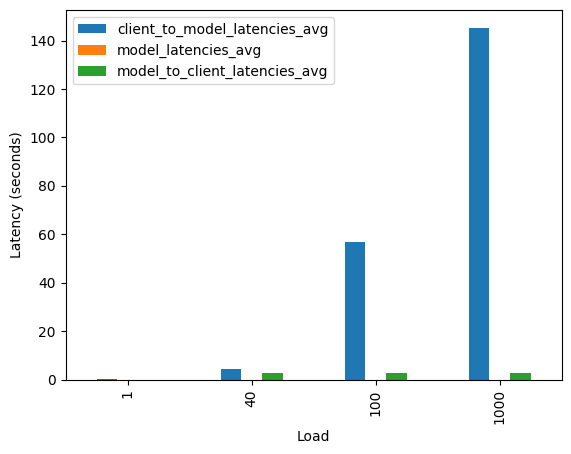

In [19]:
model_variant = 0
experiment_ids = key_config_df[
    key_config_df['model_variant'] == model_variant]['experiment_id'].tolist()
metadata_columns = ['model_variant', 'max_batch_size', 'cpu_request', 'load']
results_columns = ['client_to_model_latencies_avg', 'model_latencies_avg', 'model_to_client_latencies_avg']
output = loader1.table_maker(
    experiment_ids=experiment_ids,
    metadata_columns=metadata_columns,
    results_columns=results_columns)
display(output)
ax = output.plot.bar(x='load', y=['client_to_model_latencies_avg', 'model_latencies_avg', 'model_to_client_latencies_avg'])
ax.set_xlabel("Load")
ax.set_ylabel("Latency (seconds)")

In [21]:
import time
results = loader1.read_results()
experiment_id = 4
responses = loader1.flatten_results(results[str(experiment_id)]['responses'])
sending_times = []
for response in responses:
    try:
        sending_time = time.ctime(response['timing']['sending_time'])
        model_arrival_time = time.ctime(
        json.loads(
            response['outputs'][0][
                'data'][0])['time']['arrival_mock_one'])
        arrival_time = time.ctime(response['timing']['arrival_time'])
    except KeyError:
        # print('timed out!')
        pass
    print(f"sending time: {sending_time}, model_arrival_time: {model_arrival_time}, arrival time: {arrival_time}")

sending time: Sat Nov  5 00:29:47 2022, model_arrival_time: Sat Nov  5 00:29:49 2022, arrival time: Sat Nov  5 00:29:51 2022
sending time: Sat Nov  5 00:29:47 2022, model_arrival_time: Sat Nov  5 00:29:51 2022, arrival time: Sat Nov  5 00:29:54 2022
sending time: Sat Nov  5 00:29:47 2022, model_arrival_time: Sat Nov  5 00:29:57 2022, arrival time: Sat Nov  5 00:29:58 2022
sending time: Sat Nov  5 00:29:47 2022, model_arrival_time: Sat Nov  5 00:29:51 2022, arrival time: Sat Nov  5 00:29:54 2022
sending time: Sat Nov  5 00:29:47 2022, model_arrival_time: Sat Nov  5 00:29:50 2022, arrival time: Sat Nov  5 00:29:52 2022
sending time: Sat Nov  5 00:29:47 2022, model_arrival_time: Sat Nov  5 00:29:48 2022, arrival time: Sat Nov  5 00:29:50 2022
sending time: Sat Nov  5 00:29:47 2022, model_arrival_time: Sat Nov  5 00:29:53 2022, arrival time: Sat Nov  5 00:29:54 2022
sending time: Sat Nov  5 00:29:47 2022, model_arrival_time: Sat Nov  5 00:29:51 2022, arrival time: Sat Nov  5 00:29:54 2022


In [22]:
model_variant = 0
experiment_ids = key_config_df[
    key_config_df['model_variant'] == model_variant]['experiment_id'].tolist()
metadata_columns = ['model_variant', 'max_batch_size', 'cpu_request', 'load', 'load_duration']
results_columns = ['duration', 'timeout_count']
output = loader1.table_maker(
    experiment_ids=experiment_ids,
    metadata_columns=metadata_columns,
    results_columns=results_columns)
display(output)

model_variant  max_batch_size  cpu_request  load  load_duration  duration  \
0              0               1            4     1             60        63   
1              0               1            4    40             60        66   
2              0               1            4   100             60       175   
3              0               1            4  1000             60       359   

   timeout_count  
0              0  
1              0  
2              0  
3          50254